In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
custom_ratios_df = pd.read_csv('/content/sample_data/ecommerce_customer_data_custom_ratios.csv')
large_df= pd.read_csv('/content/sample_data/ecommerce_customer_data_large.csv')

In [10]:
# Check for missing values

print(custom_ratios_df.isnull().sum())



Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47596
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64


In [11]:
custom_ratios_df.fillna(method='ffill', inplace=True)

<ipython-input-11-287318fa3258>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  custom_ratios_df.fillna(method='ffill', inplace=True)


In [12]:
print(custom_ratios_df.duplicated().sum())

0


In [13]:
large_df['Purchase Date'] = pd.to_datetime(large_df['Customer ID'])

In [18]:
def cohort_analysis(df):

#Ensure 'transaction_date' is a datetime object

  df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

#Create 'cohort_month' column
  df['cohort_month'] = df['Purchase Date'].dt.to_period('M')

#Aggregate data by cohort and customer_id
  cohort_data = df.groupby(['cohort_month', 'Customer ID']).agg({ 'Purchase Date': 'min', # First transaction date
                                                                 'Total Purchase Amount': 'sum' # Total purchase amount

   }).reset_index()



#Rename columns for clarity

  cohort_data.rename(columns={

  'Purchase Date': 'first_purchase_date',

  'Total Purchase Amount': 'total_purchase_amount'

  }, inplace=True)

  return cohort_data

cohort_df = cohort_analysis(large_df)

print(cohort_df.head ())

  cohort_month  Customer ID                 Purchase Date  \
0      1970-01            1 1970-01-01 00:00:00.000000001   
1      1970-01            2 1970-01-01 00:00:00.000000002   
2      1970-01            3 1970-01-01 00:00:00.000000003   
3      1970-01            4 1970-01-01 00:00:00.000000004   
4      1970-01            5 1970-01-01 00:00:00.000000005   

   total_purchase_amount  
0                   6290  
1                  16481  
2                   9423  
3                   7826  
4                   9769  


In [16]:
large_df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,1970-01-01 00:00:00.000044605,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,1970-01-01 00:00:00.000044605,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,1970-01-01 00:00:00.000044605,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,1970-01-01 00:00:00.000044605,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,1970-01-01 00:00:00.000044605,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


In [17]:
custom_ratios_df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


In [21]:
reference_date = large_df['Purchase Date'].max() + pd.DateOffset(1)


#RFM Calculation

rfm_df = large_df.groupby('Customer ID').agg({
'Purchase Date': lambda x: (reference_date- x.max()).days,

'Customer ID': 'count',

'Total Purchase Amount': 'sum'

}).rename(columns={

'Purchase Date': 'recency',

'Customer ID': 'frequency',

'Total Purchase Amount': 'monetary'



}).reset_index()

print(rfm_df.head())

   Customer ID  recency  frequency  monetary
0            1        1          3      6290
1            2        1          6     16481
2            3        1          4      9423
3            4        1          5      7826
4            5        1          5      9769


In [22]:
print(rfm_df['recency'].describe())

print(rfm_df['frequency'].describe())

print(rfm_df['monetary'].describe())

count    49661.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: recency, dtype: float64
count    49661.000000
mean         5.034131
std          2.199399
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max         17.000000
Name: frequency, dtype: float64
count    49661.000000
mean     13719.947222
std       6811.065854
min        125.000000
25%       8718.000000
50%      13008.000000
75%      17921.000000
max      50659.000000
Name: monetary, dtype: float64


In [26]:
def rfm_segment(df):

#Avoid issues with non-unique bin edges by ensuring bins are strictly increasing

 recency_max = df['recency'].max()
 frequency_max = df['frequency'].max()
 monetary_max = df['monetary'].max()

#Define bins with realistic ranges
 recency_bins = [0, 30, 60, 90, recency_max]
 frequency_bins = [0, 5, 10, 15, frequency_max]
 monetary_bins = [0, 50, 100, 200, monetary_max]



#Ensure bin edges are increasing
 recency_bins = sorted(set(recency_bins))
 frequency_bins= sorted(set (frequency_bins))
 monetary_bins = sorted (set(monetary_bins))

#Create segments using pd.cut
 df['recency_segment'] = pd.cut(df['recency'], bins=recency_bins, labels=['1', '2', '3', '4'], include_lowest=True)
 df['frequency_segment'] = pd.cut(df['frequency'], bins =frequency_bins, labels=['4', '3', '2', '1'], include_lowest=True)
 df['monetary_segment'] = pd.cut(df['monetary'], bins=monetary_bins, labels=['4', '3', '2', '1'], include_lowest=True)



#Create combined RFM segment

 df['rfa_segment'] = df[['recency_segment', 'frequency_segment', 'monetary_segment']].apply(lambda x: ''.join(x), axis=1)
 return df
rfm_df = rfm_segment(rfm_df)
print(rfm_df.head())

   Customer ID  recency  frequency  monetary recency_segment  \
0            1        1          3      6290               1   
1            2        1          6     16481               1   
2            3        1          4      9423               1   
3            4        1          5      7826               1   
4            5        1          5      9769               1   

  frequency_segment monetary_segment rfa_segment  
0                 4                1         141  
1                 3                1         131  
2                 4                1         141  
3                 4                1         141  
4                 4                1         141  


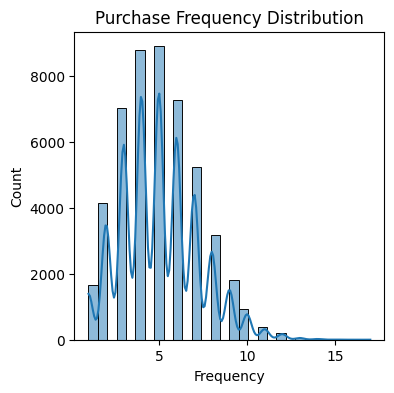

In [28]:
plt.figure(figsize=(4,4))

sns.histplot(rfm_df['frequency'], bins=30, kde=True)

plt.title('Purchase Frequency Distribution')

plt.xlabel('Frequency')

plt.ylabel('Count')

plt.show()

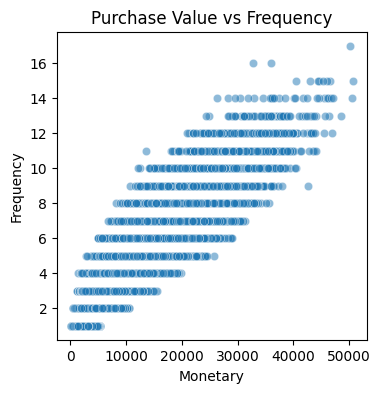

In [29]:
plt.figure(figsize=(4,4))



sns.scatterplot(data=rfm_df, x='monetary', y='frequency', alpha=0.5)

plt.title('Purchase Value vs Frequency')

plt.xlabel('Monetary')

plt.ylabel('Frequency')

plt.show()

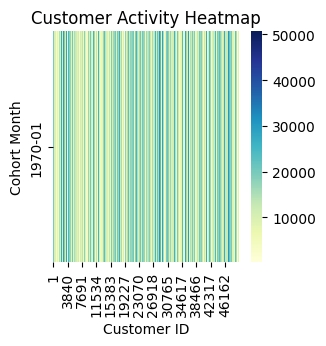

In [31]:
cohort_pivot = cohort_df.pivot_table(index='cohort_month', columns='Customer ID', values='total_purchase_amount', aggfunc='sum')

plt.figure(figsize=(3,3))

sns.heatmap(cohort_pivot, cmap='YlGnBu', annot=False)

plt.title('Customer Activity Heatmap')

plt.xlabel('Customer ID')

plt.ylabel('Cohort Month')

plt.show()




In [34]:
def generate_report(df): # Change the input variable name to df
    total_customers = df['Customer ID'].nunique()
    average_recency = df['recency'].mean()
    average_frequency = df['frequency'].mean()
    average_monetary = df['monetary'].mean()
    report = f"""
    Customer Analysis Report

    Total Customers: {total_customers}
    Average Recency (days): {average_recency:.2f}
    Average Frequency: {average_frequency:.2f}
    Average Monetary Value: {average_monetary:.2f}
    """
    return report

report = generate_report(rfm_df)  # Pass rfm_df as argument
print(report)


    Customer Analysis Report
    
    Total Customers: 49661
    Average Recency (days): 1.00
    Average Frequency: 5.03
    Average Monetary Value: 13719.95
    
